# Part I: Conceptual exercises

**1. Label each case as describing either data mining (DM), or the use of the results of data mining (Use).**

a) Choose customers who are most likely to respond to an on-line ad. USE

b) Discover rules that indicate when an account has been defrauded. DM

c) Find patterns indicating what customer behavior is more likely to lead to response to an on-line ad. DM

d) Estimate probability of default for a credit application. USE

e) Predict whether a customer is pregnant. USE


**2)  Plumbing Inc. has been selling plumbing supplies for the last 20 years. The owner, Joe, decides that next year it is finally time to diversify by adding gardening tools to his products. Having had success using customer data to build predictive models to guide direct mail campaigns for special plumbing offers, he considers that data mining could help him to identify a subset of customers who should be good prospects for his new set of products. Is Joe ready to solve this as a supervised learning problem? If yes – what would you suggest as the target variable?  If no  - why not?  What would you recommend that Joe do to achieve his business goal? **

##### Your answer goes here
No.  Joe does not have any appropriate labeled data from which to induce a model.  (Since next year it is time to diversify, he hasn’t done so yet, so has had no gardening tool campaigns.)   [This idea is covered in Chapter 2 under Data Understanding, and also in the section on Supervised vs. Unsupervised.]

[He could invest in data by running some test campaigns now, to gather data to see what sort of consumers might be responsive.  Compare with the Signet Bank case in Chapter 1.]


# Part II: Predicting Show-Up

The purpose of this part of the homework is to get you up to speed with data manipulation and model fitting using Python. Ideally, you should be able to start working on your term project after finishing this.

### Background

You've been hired as the manager of Sacred Heart Medical Clinic (SHMC). As part of its business model, SHMC usually employs doctors on demand, meaning that doctors are asked to come only when there are appointments. However, once a doctor has been asked to come, you must pay him or her regardless of whether the patient shows up or not. You want to use data on previous appointments to figure out whether you can predict which patients are going to show up, so that you can plan better how many doctors to call.

In [1]:
import pandas as pd

data_path = "data/data-hw2.csv" 

### Loading the data

** 1. Load the data referenced by the path above into a pandas data frame. Print the total number of rows and show the first few rows in the dataset. ** 

In [2]:
data = pd.read_csv(data_path)
print(data.shape)
data.head()

(110527, 14)


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589980e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262960e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679510e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841190e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Here's a brief summary of the variables you should see:

1. PatientId - Identification of a patient.
2. AppointmentID - Identification of each appointment.
3. Gender - Male or female. 
4. ScheduledDay - The day someone called or registered the appointment.
6. AppointmentDay - The day of the actual appointment, when the patient has to visit the doctor. 
7. Age = How old is the patient. 
8. Neighborhood - Place where the patient lives. 
9. Scholarship - Whether the patient receives financial help.
10. Hypertension - Whether the patient suffers from hypertension.
11. Diabetes - Whether the patient suffers from diabetes.
12. Alcoholism - Whether the patient suffers from alcoholism.
13. Handicap - Whether the patient is handicapped.
14. SMS_received - Whether 1 or more SMS messages were sent to the patient
15. No-show - Whether the patient missed the appointment.

** 2. Check out if there are any Na or NaN values. Drop all the observations that include such values in any of the columns. ** 

In [3]:
#Na per column
na_col = data.isnull().sum()
#total Na Values
print(na_col.sum())
#There are no Na Values

0


### Dealing with dates

** 3. Transform ScheduledDay and AppointmentDay into datetimes (Hint: Use pandas for this). **

In [4]:
from pandas import datetime
data['ScheduledDay'] = pd.to_datetime(data['ScheduledDay'])
data['AppointmentDay'] = pd.to_datetime(data['AppointmentDay'])
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null datetime64[ns]
AppointmentDay    110527 non-null datetime64[ns]
Age               110527 non-null int64
Neighborhood      110527 non-null object
Scholarship       110527 non-null int64
Hypertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handicap          110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: datetime64[ns](2), float64(1), int64(8), object(3)
memory usage: 11.8+ MB
None


** 4. If you take a look at both dates, you will see that ScheduledDay includes a specific time with the date, but AppointmentDay doesn't. In order to compare both fields more easily, "normalize" ScheduledDay (i.e., keep only the dates). Hint: See the [normalize](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.dt.normalize.html) method. **

In [5]:
data['ScheduledDay'] = data['ScheduledDay'].dt.normalize()
data.head()['ScheduledDay']

0   2016-04-29
1   2016-04-29
2   2016-04-29
3   2016-04-29
4   2016-04-29
Name: ScheduledDay, dtype: datetime64[ns]

** 5. Create a new column called 'TimeInAdvance' for the difference in days between ScheduledDay and AppointmentDay. Make sure that the new field includes only integers (and not TimeDelta, which is the difference between two datetimes).**

In [6]:
data['TimeInAdvance'] = (data['AppointmentDay'] - data['ScheduledDay']).dt.days
data.head()['TimeInAdvance']

0    0
1    0
2    0
3    0
4    0
Name: TimeInAdvance, dtype: int64

There are many other features you may want to extract from date variables, such as the time at which the appointment was schedule, the day of the week, the month, etc. However, we will only use TimeInAdvance for the purposes of this homework.

### Cleaning data

**6. Use the "describe" command from pandas to obtain some general stats about the data (in case you forgot about it, take a look at the 'Dealing with data' notebook in Module 1). Do you see any weird values in any of the columns? Remove all observations that include "weird" or wrong values and comment on why did you remove such observations. Also, print the number of observations you removed. **

In [7]:
data.describe()

,PatientId,AppointmentID,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,TimeInAdvance
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,10.183702
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,15.254996
min,3.920000e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000
25%,4.172615e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173180e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,9.439170e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,15.000000
max,9.999820e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,179.000000


In [8]:
#Age column seems to have wrong values, nobody could have -1 years or 115. 
#Handicap should be a binary value, 4 is not a valid value.
#TimeInAdvance should be equal or greater than 0.
original_size = data.shape[0]

data = data[data['Age'] <= 100]
data = data[data['Age'] >= 0]
data = data[data['Handicap'] <=1]
data = data[data['TimeInAdvance'] >= 0]

new_size = data.shape[0]
print(original_size - new_size)

212


### Dealing with binary variables

** 7. Create a new column called "IsFemale" that is 1 if the patient is female and 0 otherwise. Hint: Take a look at the [where](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.where.html) method. Make sure to also drop the Gender column.  **

In [9]:
import numpy as np
data['IsFemale'] = np.where(data['Gender']=='F',1,0)
data.drop(['Gender'], axis="columns", inplace=True)
data.head()['IsFemale']

0    1
1    0
2    1
3    1
4    1
Name: IsFemale, dtype: int32

** 8. Do the same for the No-show variable. It should be 1 if the person didn't show and 0 otherwise. **

In [10]:
data['DidNotShow'] = np.where(data['No-show']=='Yes',1,0)
data.drop(['No-show'], axis="columns", inplace=True)
data.head()['DidNotShow']

0    0
1    0
2    0
3    0
4    0
Name: DidNotShow, dtype: int32

### Dealing with categorical variables

** 9. Let's take a look at the Neighbordhood column. How many unique neighborhoods are there? Which are the 5 most common neighborhoods? Which are the 5 least common ones?  ** 

In [11]:
counts = data.Neighborhood.value_counts()
#Unique neighborhoods
print("Unique: {0}".format(counts.size))

#Most common neighborhoods
print("Most common:")
print(counts[:5])

#Less common neighborhoods
print("Less common:")
print(counts[-5:])

Unique: 81
Most common:
JARDIM CAMBURI     7717
MARIA ORTIZ        5804
RESISTÊNCIA        4419
JARDIM DA PENHA    3872
ITARARÉ            3507
Name: Neighborhood, dtype: int64
Less common:
ILHA DO BOI                    35
ILHA DO FRADE                  10
AEROPORTO                       8
ILHAS OCEÂNICAS DE TRINDADE     2
PARQUE INDUSTRIAL               1
Name: Neighborhood, dtype: int64


** 10. (Optional, extra points) We often group together categories that are very rare because it's hard to genearlize from them. Find the neighborhoods that appear less than 500 times in the dataset and replace their name with "OTHER". **

In [12]:
data.Neighborhood = np.where(counts[data.Neighborhood] < 500, "OTHER", data.Neighborhood)
data.head()['Neighborhood']

0    JARDIM DA PENHA
1    JARDIM DA PENHA
2      MATA DA PRAIA
3              OTHER
4    JARDIM DA PENHA
Name: Neighborhood, dtype: object

** 11. Get dummy/indicator variables for each neighborhood and add them to the dataframe. Hint: Take a look at the [get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) method. Make sure to also drop the Neighborhood column. **

In [13]:
data = pd.get_dummies(data, columns=['Neighborhood'])
data.columns

Index(['PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay', 'Age',
       'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handicap',
       'SMS_received', 'TimeInAdvance', 'IsFemale', 'DidNotShow',
       'Neighborhood_ANDORINHAS', 'Neighborhood_BELA VISTA',
       'Neighborhood_BENTO FERREIRA', 'Neighborhood_BONFIM',
       'Neighborhood_CARATOÍRA', 'Neighborhood_CENTRO',
       'Neighborhood_CONQUISTA', 'Neighborhood_CONSOLAÇÃO',
       'Neighborhood_CRUZAMENTO', 'Neighborhood_DA PENHA',
       'Neighborhood_DO CABRAL', 'Neighborhood_DO QUADRO',
       'Neighborhood_ESTRELINHA', 'Neighborhood_FONTE GRANDE',
       'Neighborhood_FORTE SÃO JOÃO', 'Neighborhood_GOIABEIRAS',
       'Neighborhood_GRANDE VITÓRIA', 'Neighborhood_GURIGICA',
       'Neighborhood_ILHA DAS CAIEIRAS', 'Neighborhood_ILHA DE SANTA MARIA',
       'Neighborhood_ILHA DO PRÍNCIPE', 'Neighborhood_INHANGUETÁ',
       'Neighborhood_ITARARÉ', 'Neighborhood_JABOUR',
       'Neighborhood_JARDIM CAMBURI

### Dealing with panel data

** 12. Let's take a look at the PatientsId column. How many patients have made more than one appointment?  **

In [14]:
(data.PatientId.value_counts() > 1).sum()

24447

As you can see, there are many patients that have made more than one appointment. Panel data (also called longitudinal data) contain observations for the same individuals over multiple periods of time. In our particuclar case, such data may help us to make better predictions. For example, the fact that a patient has failed to show up in the past may be predictive of the patient not showing up in the future. That being said, taking advantage of panel data often requires additional data processing. The following exercise is **optional** and relatively advanced, so feel free to ignore it. 

** 13. (Optional, extra points) Create a new column called "PreviousNoShows" that for each appointment includes the number of past appointments to which the patient did not show. For example, if the person did not show to the first meeting, PreviousNoShows should be 0 for the first appointment and 1 for the second one (if there is any). Hint: Sort the dataframe by PatientID and ScheduledDay. Then, group by PatientID and compute the cumulative sum of the No-show variable. All of these things can be done using pandas. **

In [15]:
data = data.sort_values(["PatientId", "ScheduledDay"])
data["PreviousNoShows"] = data.groupby("PatientId")["DidNotShow"].cumsum() - data["DidNotShow"]
data.head(30)[["PatientId", "ScheduledDay", "DidNotShow", "PreviousNoShows"]].head(20)

,PatientId,ScheduledDay,DidNotShow,PreviousNoShows
100517,39200.0,2016-05-31,0,0
105430,43700.0,2016-06-01,0,0
3950,93800.0,2016-05-18,0,0
73303,142000.0,2016-04-29,0,0
73228,538000.0,2016-04-29,0,0
54611,5628261.0,2016-05-10,1,0
40692,11831856.0,2016-05-19,0,0
58616,22638656.0,2016-04-14,0,0
88585,22638656.0,2016-05-18,0,0
49826,52168938.0,2016-04-20,0,0


There are many other features we could compute with this data set, such as time between appointments, number of past appointments, fraction of appointments to which the patient did not show up, etc. However, for the purposes of this homework, we will only work with PreviousNoShows.

### Removing the unnecessary

**14. Let's drop the columns we won't be needing. Drop PatientId, AppointmentID, ScheduledDay, AppointmentDay. **

In [16]:
data.drop(['PatientId','AppointmentID','ScheduledDay','AppointmentDay'],axis=1,inplace=True)
data.columns

Index(['Age', 'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism',
       'Handicap', 'SMS_received', 'TimeInAdvance', 'IsFemale', 'DidNotShow',
       'Neighborhood_ANDORINHAS', 'Neighborhood_BELA VISTA',
       'Neighborhood_BENTO FERREIRA', 'Neighborhood_BONFIM',
       'Neighborhood_CARATOÍRA', 'Neighborhood_CENTRO',
       'Neighborhood_CONQUISTA', 'Neighborhood_CONSOLAÇÃO',
       'Neighborhood_CRUZAMENTO', 'Neighborhood_DA PENHA',
       'Neighborhood_DO CABRAL', 'Neighborhood_DO QUADRO',
       'Neighborhood_ESTRELINHA', 'Neighborhood_FONTE GRANDE',
       'Neighborhood_FORTE SÃO JOÃO', 'Neighborhood_GOIABEIRAS',
       'Neighborhood_GRANDE VITÓRIA', 'Neighborhood_GURIGICA',
       'Neighborhood_ILHA DAS CAIEIRAS', 'Neighborhood_ILHA DE SANTA MARIA',
       'Neighborhood_ILHA DO PRÍNCIPE', 'Neighborhood_INHANGUETÁ',
       'Neighborhood_ITARARÉ', 'Neighborhood_JABOUR',
       'Neighborhood_JARDIM CAMBURI', 'Neighborhood_JARDIM DA PENHA',
       'Neighborhood_JESUS DE NAZARE

### Predictive modeling

** 15. Let's build a model to predict if someone will not show up using a DecisionTreeClassifier. Report the training accuracy and the cross-validated accuracy using 5 folds. **

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import  cross_val_score
from sklearn.metrics import accuracy_score

target = "DidNotShow"
predictors = data.columns[data.columns != target]

X = data[predictors]
y = data[target]

model = DecisionTreeClassifier()

model.fit(X, y)
predictions = model.predict(X)
train_acc = accuracy_score(predictions, y)
cross_val_acc = cross_val_score(model, X, y, cv=5).mean()

print("Training accuracy: {0:.2f}".format(round(train_acc, 2)))
print("Cross validation accuracy: {0:.2f}".format(round(cross_val_acc, 2)))

C:\Users\ferlo\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Training accuracy: 0.97
Cross validation accuracy: 0.73


** 16. As discussed in class, one way to control the complexity of a decision tree is by enforcing that at least some minimum number of examples from the training set populate each leaf. This is set with the min_samples_leaf parameter. Try values for min_samples_leaf ranging from 1 to 4096 by doubling the number of samples (i.e., 1, 2, 4, 8, ..., 4096). For each value, compute the training accuracy and the cross-validated accuracy. Use the results to plot fitting curves and explain what they show. What do you think is the most appropriate value for min_samples_leaf for this problem? ** 

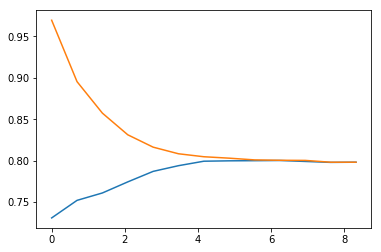

In [18]:
import matplotlib.pyplot as plt

list_cv = []
list_train = []
leaf_val = []
leaf = 1
while leaf < 4097:    
    model = DecisionTreeClassifier(min_samples_leaf=leaf)
    model.fit(X, y)
    predictions = model.predict(X)
    train_acc = accuracy_score(predictions, y)
    cross_val_acc = cross_val_score(model, X, y, cv=5).mean()
    leaf_val.append(leaf)
    leaf=leaf*2
    list_cv.append(cross_val_acc)
    list_train.append(train_acc)
    

# I'll use logarithmic scale to plot the graph
log_scale = np.log(leaf_val)
plt.plot(log_scale, list_cv)
plt.plot(log_scale, list_train)
plt.show()

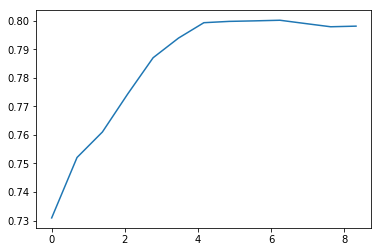

In [19]:
# Plot just cross_validation
plt.plot(log_scale, list_cv)
plt.show()

In [20]:
# The most appropriate value should be a min_samples_leaf between these two values:
print("{0:.0f}".format(np.exp(4)))
print("{0:.0f}".format(np.exp(6)))
# These values have the largest cross_validation accuracy

55
403


** 17. (Optional, extra points) Do you think the accuracy of the model you built is good or not? Why? What other addititonal information would be useful to evaluate whether the model is any good? How would you use that information to evaluate the model? **

The accuracy is not good. You can obtain an accuracy of roughly 80% by predicting that people are always going to show up.

However, this does **not** mean that the model has zero predictive power. For example, it may be the case that the model is useful to estimate the probability of people not showing up. It just happens that everybody has a probability of showing up that is greater than 50%, and so the model predicts "Show-up" for everyone. If this is the case, the model may be useful to predict the overall number of people that would arrive in a given day. This would allow to plan better how many doctors to call. So, we could test how good is the model at predicting the total number of people that will arrive any given day.